In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from lib import *
plt.style.use('../peptidome.mplstyle')
from matplotlib.lines import Line2D
from common import labels as model_to_label

In [115]:
proteomes = ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses', 'Malaria', 'Tuberculosis', 'Listeria', 'StrepA', ]
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
k = 9
dkls = pd.DataFrame(data={ model:
                          [float(pd.read_csv('data/{proteome}_{model}_k{k}_dkl.csv'.format(proteome=proteome,
                                                                            model=model, k=k))['Human'])
                            if not proteome == 'Human' else 0.0 for proteome in proteomes]
                          for model in models}
                    , index=proteomes)
dkls

,independent,ncov,nskew,nskewfcov
Human,0.000000,0.000000,0.000000,0.000000
Mouse,0.002779,0.004675,0.005751,0.008042
Chicken,0.004093,0.008983,0.014811,0.026510
Zebrafish,0.025243,0.031387,0.034851,0.047840
Humanviruses,0.091598,0.120128,0.136197,0.178177
Malaria,2.177257,1.730172,1.834071,1.975289
Tuberculosis,0.701787,0.654891,0.698379,0.788998
Listeria,0.431025,0.426684,0.434977,0.499468
StrepA,0.363996,0.377792,0.388430,0.480075


In [116]:
Sind = np.log(naminoacids)*k
dkls_rand = pd.DataFrame(data={ model:
                          [Sind - float(pd.read_csv('data/{proteome}_{model}_k{k}_entropy.csv'.format(proteome=proteome,
                                                                            model=model, k=k),
                                            index_col=0, header=None).loc['S'])
                            for proteome in proteomes]
                          for model in models}
                    , index=proteomes)
dkls_rand

,independent,ncov,nskew,nskewfcov
Human,0.926214,1.049141,1.105802,1.142894
Mouse,0.892078,0.995318,1.040346,1.088147
Chicken,0.865688,0.994480,1.040970,1.081876
Zebrafish,0.826642,0.915664,0.961872,1.009914
Humanviruses,0.840005,1.032879,1.084267,1.129217
Malaria,2.073057,2.295436,2.323767,2.454392
Tuberculosis,1.876670,1.964917,2.031196,2.106428
Listeria,1.210957,1.254488,1.292934,1.363473
StrepA,1.180569,1.220455,1.259451,1.354009


In [83]:
def mscatter(x,y, ax=None, m=None, **kwargs):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x, y, **kwargs)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        legend_handles = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
            legend_handles.append(Line2D([0], [0], marker=marker, ls=''))
        sc.set_paths(paths)
    return sc, legend_handles

In [84]:
def plot_lineandscatter(x, y, label=None, ax=None, markers=['o', 's', '>', 'd']):
    if not ax:
        ax = plt.gca()
    l, = ax.plot(x, y, ls='-', label=label)
    sc, legend_handles = mscatter(x, y, m=markers, ax=ax, s=10)
    return l, sc, legend_handles

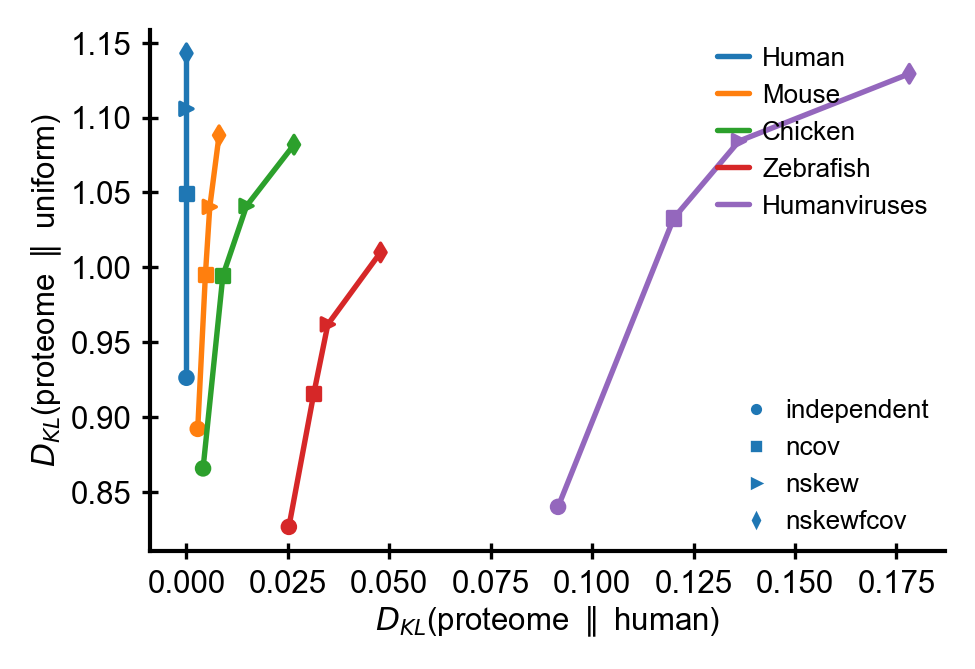

In [118]:
fig, ax = plt.subplots()
for proteome in ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses']:
    l, sc, legend_handles = plot_lineandscatter(dkls.loc[proteome], dkls_rand.loc[proteome], label=proteome)
l1 = ax.legend(ncol=1, loc='upper right')
l2 = ax.legend(legend_handles, models)
ax.add_artist(l1)
ax.set_xlabel('$D_{KL}$(proteome $\parallel$ human)')
ax.set_ylabel('$D_{KL}$(proteome $\parallel$ uniform)');

In [154]:
class smart_dict(dict):
    def __missing__(self, key):
        return key
proteome_to_label = smart_dict()
proteome_to_label['Humanviruses'] = 'Viruses'
proteome_to_label['Malaria'] = 'P. falciparum'

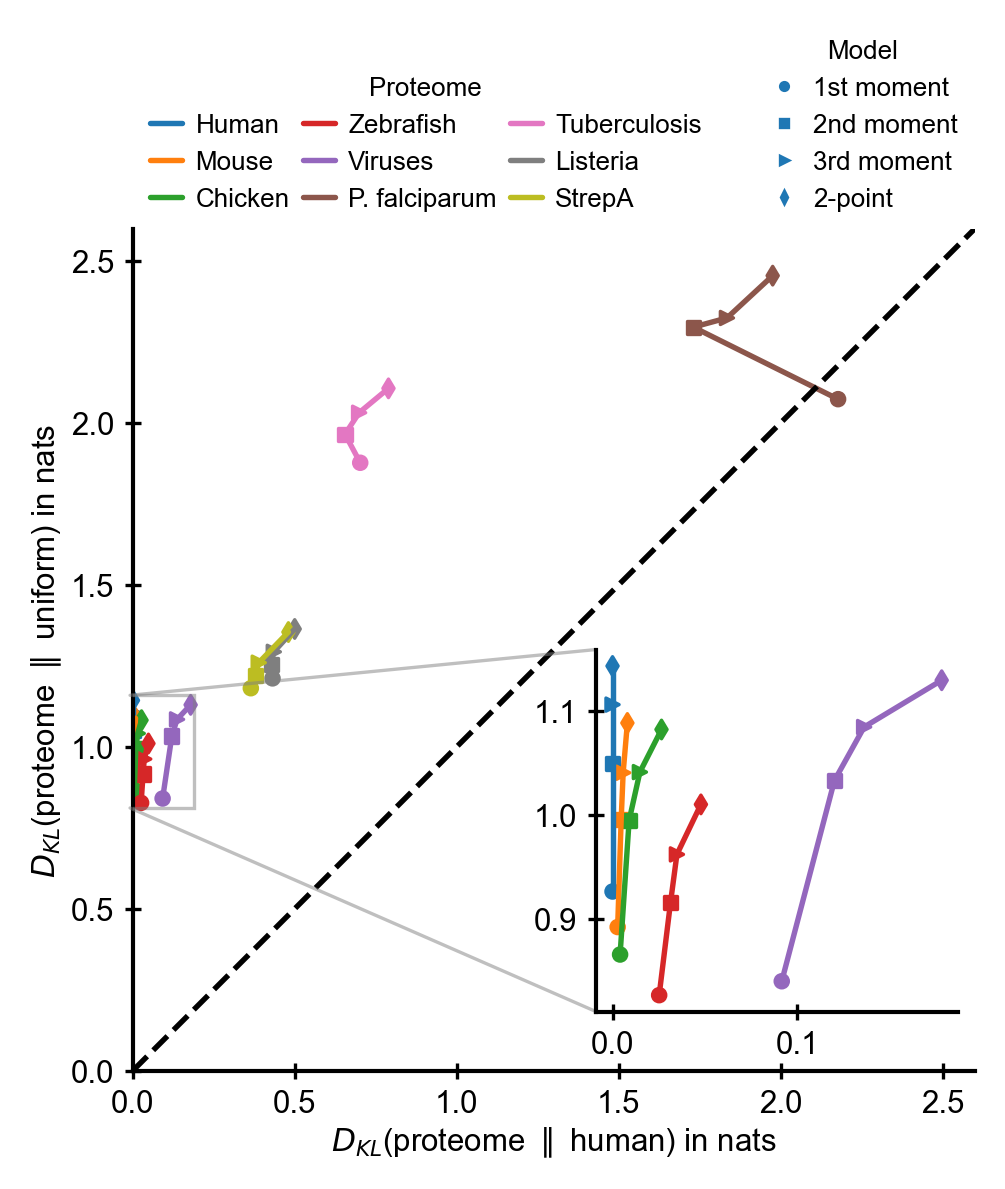

In [165]:
lim = 2.6
fig, ax = plt.subplots(figsize=(3.42, 4.0))
for proteome in proteomes:
    l, sc, legend_handles = plot_lineandscatter(dkls.loc[proteome],
                                                dkls_rand.loc[proteome],
                                                label=proteome_to_label[proteome],
                                                ax=ax)
ax.plot([0, lim], [0, lim], 'k--')
l1 = ax.legend(ncol=3, loc='lower left',
               title='Proteome', bbox_to_anchor=(0.0, 1.0))
l2 = ax.legend(legend_handles, [model_to_label[m] for m in models],
               loc='lower right', title='Model', ncol=1, bbox_to_anchor=(1.0, 1.0))
ax.add_artist(l1)
ax.set_xlim(-0.0, lim)
ax.set_ylim(-0.0, lim)
ax.set_xlabel('$D_{KL}$(proteome $\parallel$ human) in nats')
ax.set_ylabel('$D_{KL}$(proteome $\parallel$ uniform) in nats')
ax.set_aspect('equal')

axins = ax.inset_axes((0.55, 0.07, 0.43, 0.43))
for proteome in ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses']:
    plot_lineandscatter(dkls.loc[proteome], dkls_rand.loc[proteome], label=proteome, ax=axins)
rectangle_patch, connector_lines = ax.indicate_inset_zoom(axins)
#lower_left, upper_left, lower_right, upper_right = connector_lines

fig.tight_layout()
fig.savefig(figuredir + 'dkls.svg')
